## In version 2, we find communities first, then we delete the nodes from the network.

In [ ]:
library('igraph')
g <- read.graph('./data/movie_edge_weight.txt', format='ncol', directed=FALSE)

In [ ]:
#genreate genre
movie_genre_file <- file("./data/movieID_genre.txt", open="r")
line <- readLines(movie_genre_file, 1, encoding="latin1")
genre_list <- rep("", vcount(g))
while(length(line) != 0) {
    line <- strsplit(line,"\t\t")
    genre <- line[[1]][3]
    movie_id <- line[[1]][2]
    node_id <- V(g)[V(g)$name == movie_id]
    genre_list[node_id] <- genre
    line <- readLines(movie_genre_file, 1, encoding="latin1")
} 
close(movie_genre_file)

In [ ]:
save(genre_list, file = "./data/genreList.RData")

In [ ]:
# index the nodes
V(g)$idx <- 1:vcount(g)

V(g)$genre <- genre_list

In [ ]:
write_graph(g, "./data/movie_genre_graph.txt", format = "edgelist")

In [ ]:
# redundant step for this case
vertices <- V(g)[genre_list != ""]
g.genre <- induced_subgraph(g, vertices, impl = "copy_and_delete")

# Fast Greedy community detection
g.genre.fgc <- cluster_fast_greedy(g.genre)

In [ ]:
write_graph(g.genre, "./data/movie_genre_subgraph.txt", format = "edgelist")

In [628]:
save(g.genre.fgc, file = "./data/communitiesV2.RData")

### Question 7

### print_community_genre_info

In [ ]:
# generate n random integers
n <- 10
communities <- sample(1:length(g.genre.fgc), n, replace = FALSE)

In [ ]:
print_community_genre_info <- function(community_picked, community_set) {
    for (i in community_picked) {
        genre_list <- V(g.genre)[community_set[[i]]]$genre
        genre_list <- genre_list[genre_list != "None"]
        genre.table <- table(genre_list)
        genre.freq <- prop.table(genre.table)
    
        cat("======= Community", i, "=======\n")
        cat("============================\n")
    
        Genre <- names(genre.table)
        Count <- as.vector(genre.table)
        Freq <- as.vector(genre.freq)
        df <- data.frame(Genre, Count, Freq)
        print(df)
        cat("\n\n")
    }
}

In [528]:
print_community_genre_info(communities, g.genre.fgc)

======= Community 7 =======
         Genre Count         Freq
1       Action   569 0.0592091571
2        Adult    19 0.0019771072
3    Adventure   273 0.0284079084
4    Animation   248 0.0258064516
5    Biography    11 0.0011446410
6       Comedy   827 0.0860561915
7        Crime   232 0.0241415193
8  Documentary    71 0.0073881374
9        Drama  2535 0.2637877211
10      Family   229 0.0238293444
11     Fantasy   545 0.0567117586
12   Film-Noir     1 0.0001040583
13   Game-Show     4 0.0004162331
14     History    95 0.0098855359
15      Horror   325 0.0338189386
16       Music    51 0.0053069719
17     Musical    87 0.0090530697
18     Mystery   367 0.0381893861
19        News     1 0.0001040583
20     Romance   598 0.0622268470
21      Sci-Fi   910 0.0946930281
22       Short   405 0.0421436004
23       Sport   137 0.0142559834
24    Thriller   765 0.0796045786
25         War   268 0.0278876171
26     Western    37 0.0038501561


======= Community 2 =======
         Genre Count    

### plot_community_genre_info

In [607]:
plot_community_genre_info <- function(community_picked, community_Set, save_path) {

    for (i in community_picked) {
        genre_list <- V(g.genre)[community_Set[[i]]]$genre
        genre_list <- genre_list[genre_list != "None"]
        genre.table <- table(genre_list)
        genre.freq <- prop.table(genre.table)
    
        Genre <- names(genre.table)
        Count <- as.vector(genre.table)
        Freq <- as.vector(genre.freq)
    
        title = sprintf("Genre Distribution in Community %d", i)
        f_name <- sprintf("/D_Com_%d.png", i)
        f_name <- paste(save_path, f_name, sep="")
        png(filename=f_name)
        barplot(Count, main = title, ylab = "Count", names.arg = Genre, las=2)
        dev.off()
    }
}

In [609]:
save_path = "./plots/Q7"
plot_community_genre_info(communities, g.genre.fgc, save_path)

### Question 8(a)

In [622]:
print_community_genre_info(1:length(g.genre.fgc), g.genre.fgc)

======= Community 1 =======
         Genre Count         Freq
1       Action   667 1.339761e-02
2        Adult  2236 4.491313e-02
3    Adventure   311 6.246862e-03
4    Animation    82 1.647082e-03
5    Biography    38 7.632821e-04
6       Comedy  4970 9.982927e-02
7        Crime   865 1.737471e-02
8  Documentary  1420 2.852265e-02
9        Drama  9729 1.954203e-01
10      Family   813 1.633022e-02
11     Fantasy   687 1.379934e-02
12   Film-Noir     3 6.025911e-05
13   Game-Show     2 4.017274e-05
14     History   374 7.512303e-03
15      Horror  2200 4.419002e-02
16       Music   791 1.588832e-02
17     Musical   539 1.082655e-02
18     Mystery   821 1.649091e-02
19        News    35 7.030230e-04
20  Reality-TV     8 1.606910e-04
21     Romance  4080 8.195240e-02
22      Sci-Fi  1638 3.290148e-02
23       Short  6543 1.314251e-01
24       Sport   799 1.604901e-02
25   Talk-Show     5 1.004319e-04
26    Thriller  8499 1.707141e-01
27         War  1102 2.213518e-02
28     Western   528

In [624]:
save_path <- "./plots/Q8a"
plot_community_genre_info(1:length(g.genre.fgc), g.genre.fgc, save_path)

### Question 8(b)

In [610]:
# genre score
genre_score <- function(c, p, q) {
    log(c, base = exp(1)) * p / q
}

In [611]:
# calculate the the fraction of genre i movies in the entire data set
genre_all <- V(g.genre)$genre
genre_all <- genre_all[genre_all != "None"]
genre.table.all <- table(genre_all)
genre.freq.all <- prop.table(genre.table.all)

### print_community_genre_score

In [612]:
print_community_genre_score <- function(community_picked, community_set) {
    for (i in community_picked) {
        genre_list <- V(g.genre)[community_set[[i]]]$genre
        genre_list <- genre_list[genre_list != "None"]
        genre.table <- table(genre_list)
        genre.freq <- prop.table(genre.table)
    
        Genre <- names(genre.table)
        Count <- as.vector(genre.table)
        Freq <- as.vector(genre.freq)
        index = names(genre.table.all) %in% Genre
        q <- as.vector(genre.freq.all)[index]
        score <- genre_score(Count, Freq, q)
    
        cat("======= Community", i, "=======\n")
        cat("============================\n")
        df <- data.frame(Genre, score)
        print(df)
        cat("\n\n")
    }
}

In [613]:
print_community_genre_score(1:length(g.genre.fgc), g.genre.fgc)

======= Community 1 =======
         Genre       score
1       Action  3.67999057
2        Adult 22.76407374
3    Adventure  2.56793139
4    Animation  3.13898332
5    Biography  2.94861487
6       Comedy  6.94766784
7        Crime  6.50679260
8  Documentary 17.13872703
9        Drama  6.94152798
10      Family  5.52745734
11     Fantasy  5.71267819
12   Film-Noir  0.05352055
13   Game-Show  0.71394587
14     History  4.60642688
15      Horror 15.32488778
16       Music 12.59390481
17     Musical  3.38735812
18     Mystery  6.40686702
19        News 10.43252857
20  Reality-TV  5.45195030
21     Romance  6.46390724
22      Sci-Fi 11.66074130
23       Short  9.63749587
24       Sport 11.19234579
25   Talk-Show  5.80205843
26    Thriller 16.81507381
27         War  5.53801620
28     Western  1.56190054


======= Community 2 =======
         Genre       score
1       Action  0.65257297
2        Adult  7.30674720
3    Adventure  7.71224235
4    Animation  1.02291791
5    Biography  7.124106

### plot_community_genre_score

In [616]:
plot_community_genre_score <- function(community_picked, community_set, save_path) {
    for (i in community_picked) {
        genre_list <- V(g.genre)[community_set[[i]]]$genre
        genre_list <- genre_list[genre_list != "None"]
        genre.table <- table(genre_list)
        genre.freq <- prop.table(genre.table)
    
        Genre <- names(genre.table)
        Count <- as.vector(genre.table)
        Freq <- as.vector(genre.freq)
    
        index = names(genre.table.all) %in% Genre
        q <- as.vector(genre.freq.all)[index]
        score <- genre_score(Count, Freq, q)
    
        title <- sprintf("Genre Score in Community %d", i)
        f_name <- sprintf("/D_Com_%d_score.png", i)
        f_name <- paste(save_path, f_name, sep="")
        png(filename=f_name)
        barplot(score, main = title, ylab = "Score", names.arg = Genre, las=2)
        dev.off()
    }
}

In [617]:
save_path = "./plots/Q8b"
plot_community_genre_score(1:length(g.genre.fgc), g.genre.fgc, save_path)

### Question 8(c)

### creat_edgelist

In [529]:
creat_edgelist <- function(file_path, movie_id_list) {
    # build the edgelist for bipartite graph
    movie_actors_file <- file(file_path, open="r")
    line <- readLines(movie_actors_file, 1, encoding="latin1")

    # index of movie_id_list
    idx <- 1

    # edgelist
    movie_id_edge <- c()
    actor_id_edge <- c()

    while(length(line) != 0) {    
        line <- strsplit(line,"\t\t")
        movie_id <- line[[1]][2]
    
        if (movie_id == movie_id_list[idx]) {
            actor_id <- line[[1]][3:length(line[[1]])]
            movie_id_edge <- c(movie_id_edge, rep(paste("m_id",movie_id),
                                              length(actor_id)))
            actor_id_edge <- c(actor_id_edge, actor_id)
            idx <- idx + 1
        }

        if (idx > length(movie_id_list)) {
            break
        }
        line <- readLines(movie_actors_file, 1, encoding="latin1")
    } 
    close(movie_actors_file)
    list(actor_id_edge, movie_id_edge)
}

### build_bipartite_graph

In [530]:
build_bipartite_graph <- function(actor_id_edge, movie_id_edge) {
    # build the bipartite graph
    edge_df <- data.frame(actor_id_edge, movie_id_edge)
    g.bi <- graph_from_data_frame(edge_df)
    V(g.bi)$type <- V(g.bi)$name %in% actor_id_edge
    g.bi
}

### plot_bipartite_graph

In [531]:
plot_bipartite_graph <- function(bipartite_graph, vsize=6, ncom) {
    l <- layout_as_bipartite(bipartite_graph)
    title <- sprintf("Actors - Movies(Community %s)", ncom)
    plot(bipartite_graph, layout=l[, c(2,1)], vertex.size= vsize, asp=0, 
         vertex.label=NA, main=title)    
}

### get_actor_movie_df
actor id - movie number

In [532]:
get_actor_movie_df <- function(bipartite_graph, actor_id_edge) {
    # act n movies
    Movie_number <- as.vector(degree(bipartite_graph, mode='out'))
    Movie_number <- Movie_number[Movie_number>0]

    # Actor id
    Actor <- names(V(bipartite_graph)[1:length(names(table(actor_id_edge)))])
    actor_movie_df <- data.frame(Actor, Movie_number)
    actor_movie_df
}

In [533]:
get_actor_movie_df(g.bi, actor_id_edge)

Actor,Movie_number
5847,1
17589,12
21871,1
22617,11
54034,1
71052,13
82626,18
84589,9
87645,14
87648,17


### get_movie_actor_df
movie id - actor number

In [534]:
get_movie_actor_df <- function(bipartite_graph, actor_id_edge) {
    # number of actors
    Actor_number <- as.vector(degree(bipartite_graph, mode='in'))
    Actor_number <- Actor_number[Actor_number>0]

    # movie id
    Movie <- names(V(bipartite_graph)[(length(names(table(actor_id_edge)))+1):vcount(bipartite_graph)])
    movie_actor_df <- data.frame(Movie, Actor_number)
    movie_actor_df    
}

In [535]:
get_movie_actor_df(g.bi, actor_id_edge)

Movie,Actor_number
m_id 102854,12
m_id 222203,5
m_id 222204,10
m_id 222205,6
m_id 222206,9
m_id 222207,6
m_id 222208,10
m_id 222209,7
m_id 222211,10
m_id 222212,6


### get_top_three

In [536]:
get_top_three <- function(actor_movie_df) {
    # the most three important actors id
    top_three <- actor_movie_df[rev(order(actor_movie_df$Movie_number)),]$Actor[1:3]
    top_three <- sort(top_three)
    top_three <- as.character(top_three)
    top_three
}


### get_actor_name

In [537]:
get_actor_name <- function(file_path, top_three) {
    actors_file <- file(file_path, open="r")
    line <- readLines(actors_file, 1, encoding="latin1")

    # index of movie_id_list
    idx <- 1

    # actor name
    actor_name <- c()

    while(length(line) != 0) {    
        line <- strsplit(line,"\t\t")
        actor_id <- line[[1]][2]
    
        if (actor_id == top_three[idx]) {
            actor_name <- c(actor_name, line[[1]][1])
            idx <- idx + 1
        }

        if (idx > length(top_three)) {
            break
        }
        line <- readLines(actors_file, 1, encoding="latin1")
    } 
    close(actors_file)
    actor_name
}


### get_movie_id

In [538]:
get_movie_id <- function(movies) {
    movie_id <- c()
    for (i in 1:length(movies)) {
        id <- strsplit(movies[i], ' ')[[1]][2]
        movie_id <- c(movie_id, id)
    }
    sort(movie_id)
}

### get_movie_genre

In [539]:
get_movie_genre <- function(genre_graph, movie_id) {
    genre <- V(genre_graph)[V(genre_graph)$name %in% movie_id]$genre
    genre
}

### get_movie_name

In [540]:
get_movie_name <- function(file_path, movie_id) {
    movie_genre_file <- file(file_path, open="r")
    line <- readLines(movie_genre_file, 1, encoding="latin1")
    movie_name <- c()
    idx <- 1
    while(length(line) != 0) {
        line <- strsplit(line,"\t\t")
        id <- line[[1]][2]
        if (movie_id[idx] == id) {
            movie_name <- c(movie_name, line[[1]][1])
            idx = idx + 1
        }
        if (idx > length(movie_id)) {
            break
        }
        line <- readLines(movie_genre_file, 1, encoding="latin1")
    } 
    close(movie_genre_file)
    movie_name
}

### print_actor_info

In [541]:
print_actor_info <- function(genre_graph, bipartite_graph, top_three, actor_name,
                             file_path) {
    for (i in 1:length(top_three)) {
        movies <- neighbors(bipartite_graph, top_three[i], mode='out')$name
        Movie_ids <- get_movie_id(movies)
        
        Names <- get_movie_name(file_path, Movie_ids)
        
        Genres <- get_movie_genre(genre_graph, Movie_ids)
        
        info.df <- data.frame(Movie_ids, Names, Genres)
        
        
        cat(actor_name[i], ":\n")
        cat("===================================\n")
        print(info.df)
        cat("\n\n")
    }
}



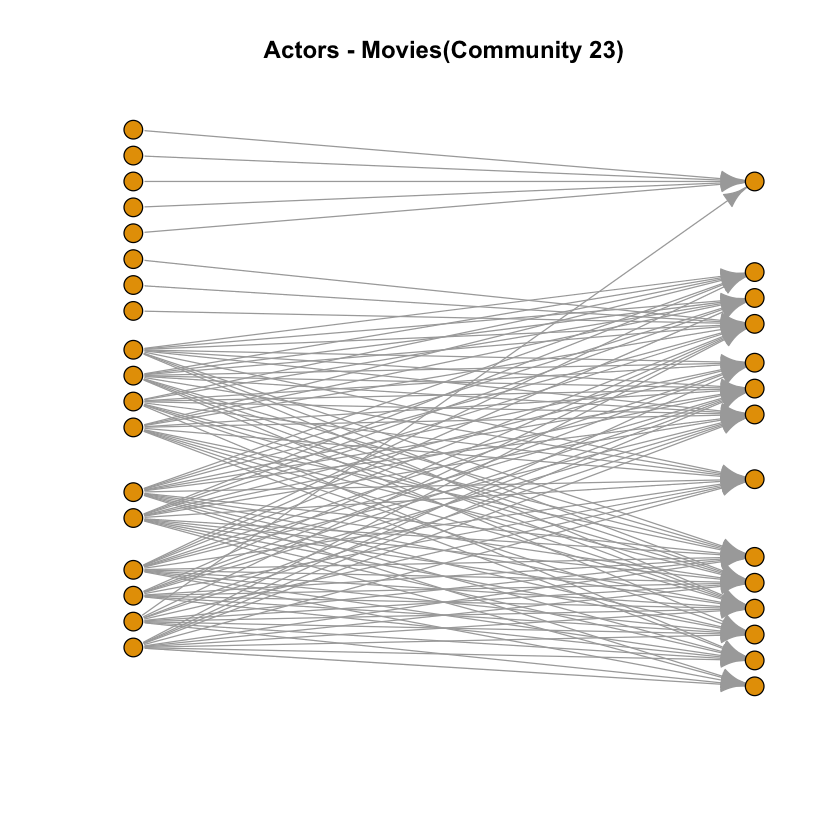

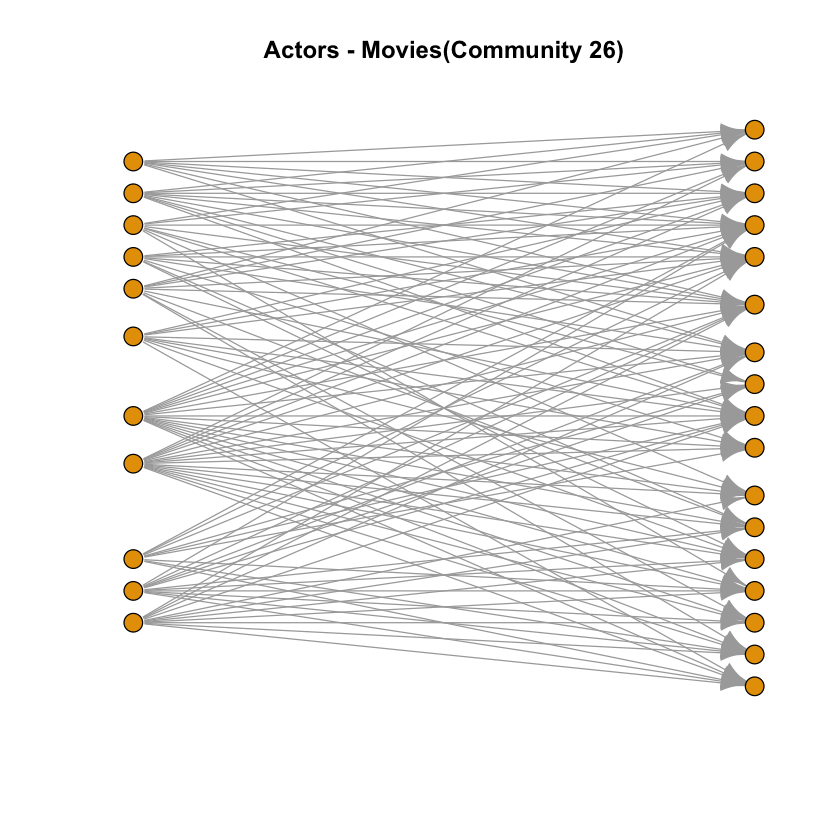

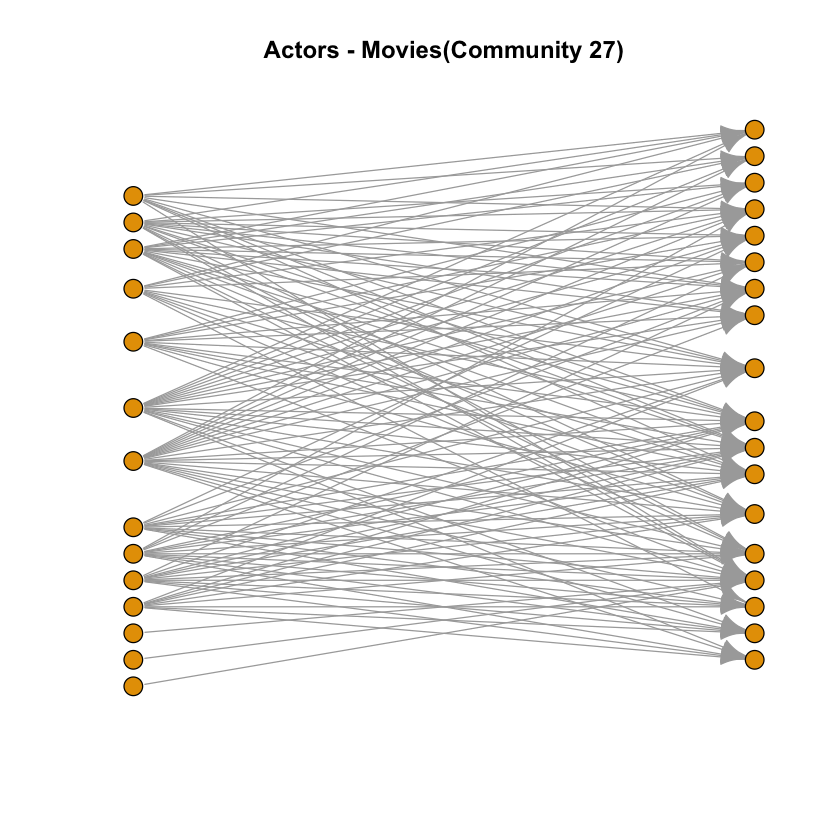

In [542]:
small_communities <- g.genre.fgc[sizes(g.genre.fgc) >= 10 & sizes(g.genre.fgc) <= 20]

# plot bipartite graph
file_path <- "./data/movie_actors.txt"

for (i in 1:length(small_communities)) {
    movie_id_list <- sort(as.numeric(V(g.genre)[small_communities[[i]]]$name))
    
    edgelist <- creat_edgelist(file_path, movie_id_list)
    actor_id_edge <- edgelist[[1]]
    movie_id_edge <- edgelist[[2]]
    
    g.bi <- build_bipartite_graph(actor_id_edge, movie_id_edge)
    plot_bipartite_graph(g.bi, ncom=names(small_communities)[i])
}


In [543]:
# genrate information about graph and top three actors
actor_id_path = "./data/actor_id.txt" 
movie_genre_path <- "./data/movieID_genre.txt"

for (i in 1:length(small_communities)) {
    # find all movies in the current community
    movie_id_list <- sort(as.numeric(V(g.genre)[small_communities[[i]]]$name))
    
    edgelist <- creat_edgelist(file_path, movie_id_list)
    actor_id_edge <- edgelist[[1]]
    movie_id_edge <- edgelist[[2]]
    
    g.bi <- build_bipartite_graph(actor_id_edge, movie_id_edge)
    
    # get actor - movie number data frame
    actor_movie_df <- get_actor_movie_df(g.bi, actor_id_edge)
    # get movie - actor number data frame
    movie_actor_df <- get_movie_actor_df(g.bi, actor_id_edge)
    
    cat("************************** Community",
        names(small_communities)[i], "**************************\n")
    cat("******************************************************************\n")
    print(actor_movie_df)
    cat("\n")
    print(movie_actor_df)
    cat("\n")

    # get three most important actor id and name
    top_three <- get_top_three(actor_movie_df)
    actor_name <- get_actor_name(actor_id_path, top_three)
    
    # print three most important actor information
    # movie id, movie name, genre
    print_actor_info(g.genre, g.bi, top_three, actor_name, movie_genre_path)
    cat("\n\n")
}

************************** Community 23 **************************
******************************************************************
    Actor Movie_number
1    5954           11
2   35416           11
3   45768           11
4   45816           11
5   55508           13
6   60493           10
7   75659           13
8   77124           13
9   13483           10
10  29011           10
11   9177            1
12  77329            1
13 110658            1
14  40461            1
15  43234            1
16  61505            1
17  92685            1
18  92697            1

         Movie Actor_number
1  m_id 104646            8
2  m_id 104647           10
3  m_id 104648           12
4  m_id 104649           10
5  m_id 104650            5
6  m_id 104651           10
7  m_id 104652           10
8  m_id 104653           10
9  m_id 104654            8
10 m_id 104655            8
11 m_id 104656           10
12 m_id 186354            7
13 m_id 186355            7
14 m_id 335256            6

Desjard

In [619]:
save_path = "./plots/Q8c"
plot_community_genre_info(as.numeric(names(small_communities)), g.genre.fgc, save_path)

## In version 3, we delete the nodes from the network first, then we find the communities

```r
# remove the movies which have no genres
load("genreList.RData")
vertices <- V(g)[genre_list != "None"]
g.genre <- induced_subgraph(g, vertices, impl = "copy_and_delete")
```

In [625]:
g.genre <- read_graph("./data/movie_genre_subgraphV3.txt", format = "edgelist")
load("./data/communitiesV3.RData")

### Question 7

In [627]:
g.genre.fgc

[1] "g.genre.fgc"

In [ ]:
# generate n random integers
n <- 10
communities <- sample(1:length(g.genre.fgc), n, replace = FALSE)